In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# ***Data Split***

In [2]:
from sklearn.model_selection import train_test_split
import os
import shutil

# Directory where your data is stored
data_directory = '/content/gdrive/MyDrive/traffic sign-speed limit'

# Output directory to save the split dataset
output_directory = '/content/gdrive/MyDrive/split_dataset_'
os.makedirs(output_directory, exist_ok=True)

# Create the train, validation, and test directories
train_dir = os.path.join(output_directory, 'train')
val_dir = os.path.join(output_directory, 'validation')
test_dir = os.path.join(output_directory, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define the percentage split for train, validation, and test sets
train_split = 0.80
test_split = 0.20

# Iterate over the class subfolders
for class_folder in os.listdir(data_directory):
    if not class_folder.startswith('.'):  # Skip hidden files like .DS_Store
        class_path = os.path.join(data_directory, class_folder)
        images = os.listdir(class_path)

        # Split images for the current class into train, validation, and test sets
        temp_images, test_images = train_test_split(images, test_size=test_split, random_state=42)
        train_images, val_images = train_test_split(temp_images, train_size=train_split, random_state=42)

        # Create subdirectories for the current class in the train, validation, and test directories
        class_train_dir = os.path.join(train_dir, class_folder)
        class_val_dir = os.path.join(val_dir, class_folder)
        class_test_dir = os.path.join(test_dir, class_folder)

        os.makedirs(class_train_dir, exist_ok=True)
        os.makedirs(class_val_dir, exist_ok=True)
        os.makedirs(class_test_dir, exist_ok=True)

        # Copy images to the respective subdirectories

        i=j=k=0
        for image in train_images:
            i+=1
            source_path = os.path.join(class_path, image)
            dest_path = os.path.join(class_train_dir, image)
            shutil.copy(source_path, dest_path)
        print("train",i)

        for image in val_images:
            j+=1
            source_path = os.path.join(class_path, image)
            dest_path = os.path.join(class_val_dir, image)
            shutil.copy(source_path, dest_path)
        print("validation",j)

        for image in test_images:
            k+=1
            source_path = os.path.join(class_path, image)
            dest_path = os.path.join(class_test_dir, image)
            shutil.copy(source_path, dest_path)
        print("test",k)
    print()
print("Dataset split into train, validation, and test sets successfully.")


train 921
validation 231
test 288

train 1267
validation 317
test 396

train 1440
validation 360
test 450

train 902
validation 226
test 282

train 134
validation 34
test 42

train 268
validation 68
test 84

train 1420
validation 356
test 444

train 902
validation 226
test 282

train 1190
validation 298
test 372

Dataset split into train, validation, and test sets successfully.


# **ResNet**

In [21]:
import cv2
import numpy as np
import os
from tensorflow.keras.utils import to_categorical

train = []
labels_train = []

validation = []
labels_val = []

test = []
labels_test = []
classes = 9  # Number of classes for traffic signs

train_dir = '/content/gdrive/MyDrive/split_dataset_/train'
val_dir = '/content/gdrive/MyDrive/split_dataset_/validation'
test_dir = '/content/gdrive/MyDrive/split_dataset_/test'

# Directory where your data is stored
for i in range(classes):
    path_train = os.path.join(train_dir, str(i))
    path_val = os.path.join(val_dir, str(i))
    path_test = os.path.join(test_dir, str(i))

    for img in os.listdir(path_train):
        img_path = os.path.join(path_train, img)
        image = cv2.imread(img_path, -1)
        image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_NEAREST)
        train.append(image)
        labels_train.append(i)

    for img in os.listdir(path_val):
        img_path = os.path.join(path_val, img)
        image = cv2.imread(img_path, -1)
        image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_NEAREST)
        validation.append(image)
        labels_val.append(i)

    for img in os.listdir(path_test):
        img_path = os.path.join(path_test, img)
        image = cv2.imread(img_path, -1)
        image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_NEAREST)
        test.append(image)
        labels_test.append(i)
# Convert the lists to NumPy arrays
train = np.array(train)
labels_train = np.array(labels_train)

validation = np.array(validation)
labels_val = np.array(labels_val)

test = np.array(test)
labels_test = np.array(labels_test)

print("Train shape:", train.shape)
print("Train Label shape:", labels_train.shape)

print("validation shape:", validation.shape)
print("Validation Label shape:", labels_val.shape)

print("Test shape:", test.shape)
print("Test Label shape:", labels_test.shape)


labels_train_one_hot = to_categorical(labels_train, classes)
labels_test_one_hot = to_categorical(labels_test, classes)
labels_val_one_hot = to_categorical(labels_val, classes)

Train shape: (8444, 224, 224, 3)
Train Label shape: (8444,)
validation shape: (2116, 224, 224, 3)
Validation Label shape: (2116,)
Test shape: (2640, 224, 224, 3)
Test Label shape: (2640,)


In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a global average pooling layer and a fully connected layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(classes, activation='softmax')(x)

# Create the full model
model_resnet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model_resnet.summary()

# Train the model
epochs = 20
batch_size = 32

callbacks = [
    ModelCheckpoint('/content/gdrive/MyDrive/split_dataset_/model_resnet.h5', save_best_only=True, verbose=1),  # Save the best model checkpoint
    TensorBoard(log_dir='./logs_resnet', histogram_freq=1, write_graph=True, write_images=True)  # TensorBoard for visualization
]

# Train the model with the defined callbacks
history = model_resnet.fit(train, labels_train_one_hot, batch_size=batch_size, epochs=epochs,
                           validation_data=(validation, labels_val_one_hot), callbacks=callbacks)

model_resnet.save('/content/gdrive/MyDrive/split_dataset_/model_resnet_final.h5')
# Evaluate the model
test_loss, test_acc = model_resnet.evaluate(test, labels_test_one_hot)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

94765736/94765736 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


264/264 [==============================] - 172s 465ms/step - loss: 0.3381 - accuracy: 0.8991 - val_loss: 0.5959 - val_accuracy: 0.8374
Epoch 2/20
264/264 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9803
Epoch 2: val_loss improved from 0.59590 to 0.00639, saving model to /content/gdrive/MyDrive/split_dataset_/model_resnet.h5
264/264 [==============================] - 110s 416ms/step - loss: 0.0626 - accuracy: 0.9803 - val_loss: 0.0064 - val_accuracy: 0.9986
Epoch 3/20
264/264 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9912
Epoch 3: val_loss did not improve from 0.00639
264/264 [==============================] - 105s 398ms/step - loss: 0.0288 - accuracy: 0.9912 - val_loss: 2.1140 - val_accuracy: 0.8233
Epoch 4/20
264/264 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9916
Epoch 4: val_loss did not improve from 0.00639
264/264 [==============================] - 102s 388ms/step - loss: 0.0306 - accuracy: 0.99

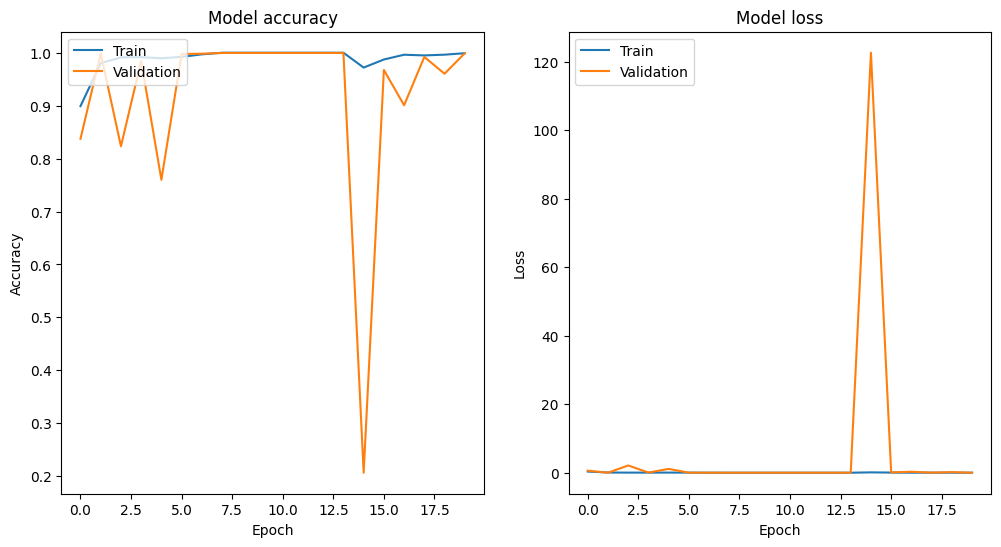

In [7]:
import matplotlib.pyplot as plt

# Get the training history from the model training
history_dict = history.history

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


83/83 [==============================] - 10s 97ms/step


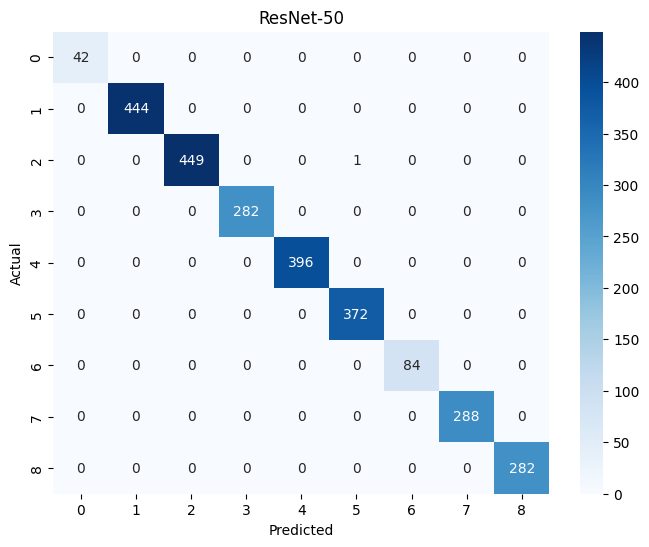

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Make predictions on the test data
y_pred = model_resnet.predict(test)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
confusion_mat_resnet = confusion_matrix(labels_test, y_pred_classes)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_resnet, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ResNet-50')
plt.show()

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Calculate Precision, Recall, and F1 Score
precision = precision_score(labels_test, y_pred_classes, average='macro')  # You can use 'micro' or 'weighted' instead of 'macro' if needed
recall = recall_score(labels_test, y_pred_classes, average='macro')
f1 = f1_score(labels_test, y_pred_classes, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calculate precision, recall, and F1 score from the confusion matrix
classification_rep = classification_report(labels_test, y_pred_classes)

# Print the classification report
print("Classification Report:\n", classification_rep)
TN = confusion_mat_resnet[0, 0]  # True Negatives
FP = confusion_mat_resnet[0, 1]  # False Positives

specificity = TN / (TN + FP)
print(f"Specificity: {specificity}")

Precision: 0.9997021149836163
Recall: 0.999753086419753
F1 Score: 0.9997272634520584
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00       444
           2       1.00      1.00      1.00       450
           3       1.00      1.00      1.00       282
           4       1.00      1.00      1.00       396
           5       1.00      1.00      1.00       372
           6       1.00      1.00      1.00        84
           7       1.00      1.00      1.00       288
           8       1.00      1.00      1.00       282

    accuracy                           1.00      2640
   macro avg       1.00      1.00      1.00      2640
weighted avg       1.00      1.00      1.00      2640

Specificity: 1.0


In [10]:
model_resnet.save('/content/gdrive/MyDrive/split_dataset_/model_resnet_final.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# ***VGG***

In [22]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard


# Load the pretrained VGG model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Remove the fully connected layers
x = base_model.output
x = Flatten()(x)

# Add a new classification layer for 9 classes
predictions = Dense(9, activation='softmax')(x)

# Create the updated model
model_vgg = Model(inputs=base_model.input, outputs=predictions)

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with an appropriate optimizer and loss function
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Display model summary
model_vgg.summary()

# Train the model
epochs = 20
batch_size = 32

callbacks = [
    ModelCheckpoint('/content/gdrive/MyDrive/split_dataset_/model_vgg.h5', save_best_only=True, verbose=1),  # Save the best model checkpoint
    TensorBoard(log_dir='./logs_vgg', histogram_freq=1, write_graph=True, write_images=True)  # TensorBoard for visualization
]

# Train the model with the defined callbacks
history= model_vgg.fit(train, labels_train_one_hot, batch_size=batch_size, epochs=epochs,
                           validation_data=(validation, labels_val_one_hot), callbacks=callbacks)

# Evaluate the model
test_loss, test_acc = model_vgg.evaluate(test, labels_test_one_hot)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

model_vgg.save('/content/gdrive/MyDrive/split_dataset_/model_vgg_final.h5')


58889256/58889256 [==============================] - 3s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


264/264 [==============================] - 52s 178ms/step - loss: 3.2993 - accuracy: 0.7170 - val_loss: 0.9271 - val_accuracy: 0.8800
Epoch 2/20
264/264 [==============================] - ETA: 0s - loss: 0.5464 - accuracy: 0.9131
Epoch 2: val_loss did not improve from 0.92709
264/264 [==============================] - 43s 161ms/step - loss: 0.5464 - accuracy: 0.9131 - val_loss: 1.1443 - val_accuracy: 0.8620
Epoch 3/20
264/264 [==============================] - ETA: 0s - loss: 0.6057 - accuracy: 0.9240
Epoch 3: val_loss did not improve from 0.92709
264/264 [==============================] - 45s 172ms/step - loss: 0.6057 - accuracy: 0.9240 - val_loss: 2.3607 - val_accuracy: 0.8483
Epoch 4/20
264/264 [==============================] - ETA: 0s - loss: 0.3994 - accuracy: 0.9516
Epoch 4: val_loss improved from 0.92709 to 0.92102, saving model to /content/gdrive/MyDrive/split_dataset_/model_vgg.h5
264/264 [==============================] - 50s 188ms/step - loss: 0.3994 - accuracy: 0.9516 - va

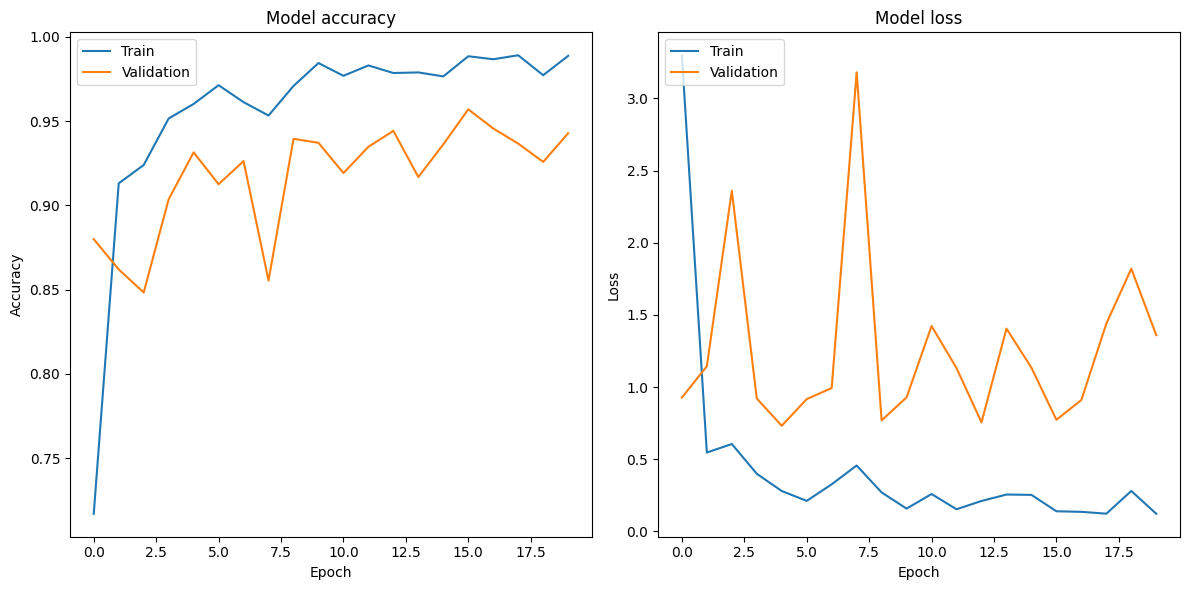

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

83/83 [==============================] - 10s 124ms/step


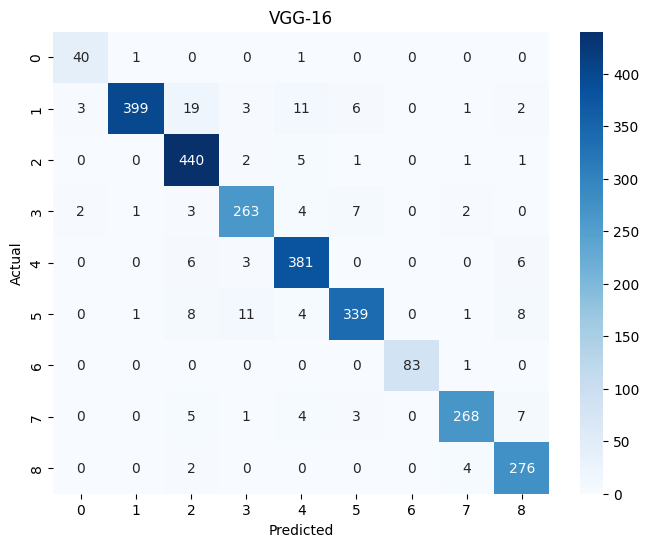

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Make predictions on the test data
y_pred = model_vgg.predict(test)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
confusion_mat_vgg = confusion_matrix(labels_test, y_pred_classes)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_vgg, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('VGG-16')
plt.show()

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Calculate Precision, Recall, and F1 Score
precision = precision_score(labels_test, y_pred_classes, average='macro')  # You can use 'micro' or 'weighted' instead of 'macro' if needed
recall = recall_score(labels_test, y_pred_classes, average='macro')
f1 = f1_score(labels_test, y_pred_classes, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calculate precision, recall, and F1 score from the confusion matrix
classification_rep = classification_report(labels_test, y_pred_classes)

# Print the classification report
print("Classification Report:\n", classification_rep)

TN = confusion_mat_vgg[0, 0]  # True Negatives
FP = confusion_mat_vgg[0, 1]  # False Positives

specificity = TN / (TN + FP)
print(f"Specificity: {specificity}")

Precision: 0.9430302410876179
Recall: 0.9480241360989474
F1 Score: 0.9447955835268763
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92        42
           1       0.99      0.90      0.94       444
           2       0.91      0.98      0.94       450
           3       0.93      0.93      0.93       282
           4       0.93      0.96      0.95       396
           5       0.95      0.91      0.93       372
           6       1.00      0.99      0.99        84
           7       0.96      0.93      0.95       288
           8       0.92      0.98      0.95       282

    accuracy                           0.94      2640
   macro avg       0.94      0.95      0.94      2640
weighted avg       0.94      0.94      0.94      2640

Specificity: 0.975609756097561


# **CNN**

In [11]:
import cv2
import numpy as np
import os
from google.colab import drive
from tensorflow.keras.utils import to_categorical

train = []
labels_train = []

validation = []
labels_val = []

test = []
labels_test = []
classes = 9  # Number of classes for traffic signs

train_dir = '/content/gdrive/MyDrive/split_dataset_/train'
val_dir = '/content/gdrive/MyDrive/split_dataset_/test'
test_dir = '/content/gdrive/MyDrive/split_dataset_/validation'
# Directory where your data is stored
for i in range(classes):
    path_train = os.path.join(train_dir, str(i))
    path_val = os.path.join(val_dir, str(i))
    path_test = os.path.join(test_dir, str(i))

    for img in os.listdir(path_train):
        img_path = os.path.join(path_train, img)
        image = cv2.imread(img_path, -1)
        image = cv2.resize(image, (30, 30), interpolation=cv2.INTER_NEAREST)
        train.append(image)
        labels_train.append(i)

    for img in os.listdir(path_test):
        img_path = os.path.join(path_test, img)
        image = cv2.imread(img_path, -1)
        image = cv2.resize(image, (30, 30), interpolation=cv2.INTER_NEAREST)
        test.append(image)
        labels_test.append(i)

    for img in os.listdir(path_val):
        img_path = os.path.join(path_val, img)
        image = cv2.imread(img_path, -1)
        image = cv2.resize(image, (30, 30), interpolation=cv2.INTER_NEAREST)
        validation.append(image)
        labels_val.append(i)

# Convert the lists to NumPy arrays
train = np.array(train)
labels_train = np.array(labels_train)

validation = np.array(validation)
labels_val = np.array(labels_val)

test = np.array(test)
labels_test = np.array(labels_test)

print("Train shape:", train.shape)
print("Train Label shape:", labels_train.shape)

print("validation shape:", validation.shape)
print("Validation Label shape:", labels_val.shape)

print("Test shape:", test.shape)
print("Test Label shape:", labels_test.shape)


labels_train_one_hot = to_categorical(labels_train, classes)
labels_test_one_hot = to_categorical(labels_test, classes)
labels_val_one_hot = to_categorical(labels_val, classes)

Train shape: (8444, 30, 30, 3)
Train Label shape: (8444,)
validation shape: (2640, 30, 30, 3)
Validation Label shape: (2640,)
Test shape: (2116, 30, 30, 3)
Test Label shape: (2116,)


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

model_cnn = tf.keras.models.Sequential([

        tf.keras.layers.Conv2D(
            32, (3,3), activation = "relu" ,input_shape = (30, 30, 3)
        ),

        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(
            32, (3,3), activation = "relu" ,input_shape = (30, 30, 3)
        ),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(128, activation = "relu"),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(9, activation = "softmax"),
    ])

# Compile the model
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model_cnn.summary()

# Train the model
epochs = 20
batch_size = 32

callbacks = [
    ModelCheckpoint('/content/gdrive/MyDrive/split_dataset_/model_cnn.h5', save_best_only=True, verbose=1),  # Save the best model checkpoint
    TensorBoard(log_dir='./logs_cnn', histogram_freq=1, write_graph=True, write_images=True)  # TensorBoard for visualization
]

history= model_cnn.fit(train, labels_train_one_hot, batch_size=batch_size, epochs=epochs,
                           validation_data=(validation, labels_val_one_hot), callbacks=callbacks)
# Evaluate the model

test_loss, test_accuracy = model_cnn.evaluate(test, labels_test_one_hot, verbose=1)

# Save the model
model_cnn.save('/content/gdrive/MyDrive/split_dataset_/model_cnn_final.h5')

# Print test loss and accuracy
print(f'Test Loss:{test_loss:.2f}')
print(f'Test Accuracy:{test_accuracy:.2f}')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               589952    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

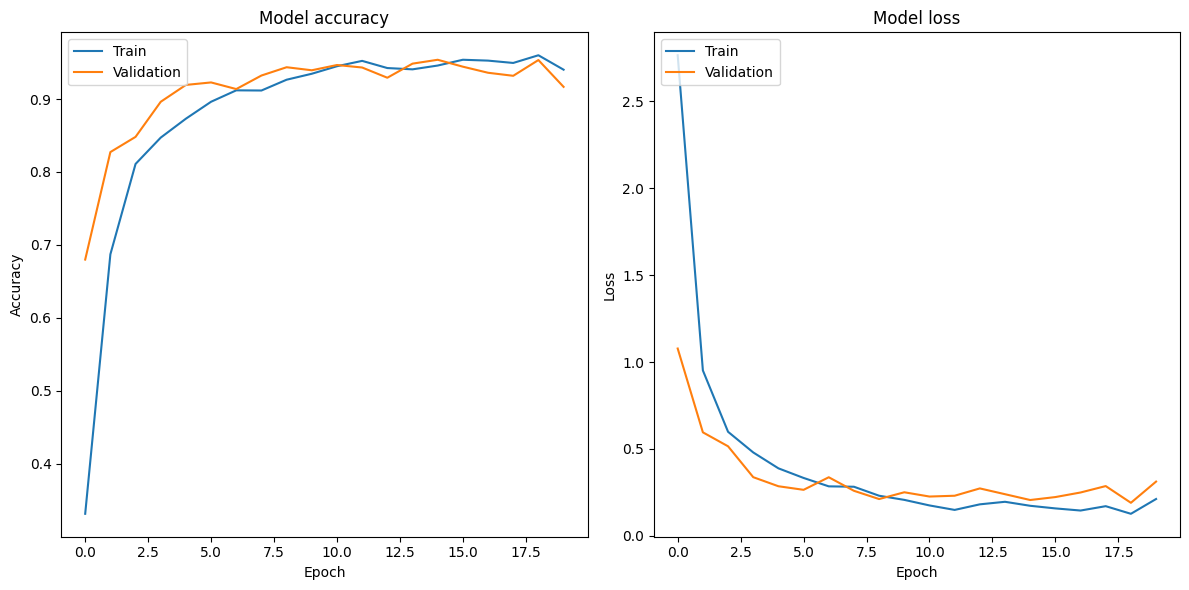

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

67/67 [==============================] - 0s 6ms/step


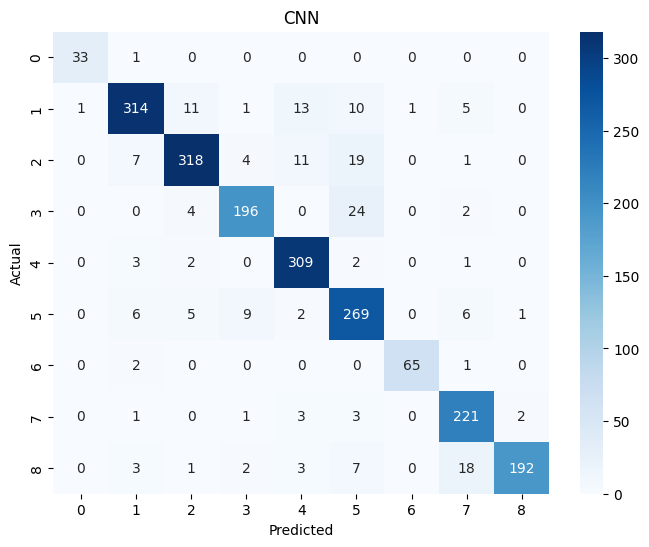

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Make predictions on the test data
y_pred = model_cnn.predict(test)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
confusion_mat_cnn = confusion_matrix(labels_test, y_pred_classes)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_cnn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN')
plt.show()

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Calculate Precision, Recall, and F1 Score
precision = precision_score(labels_test, y_pred_classes, average='macro')  # You can use 'micro' or 'weighted' instead of 'macro' if needed
recall = recall_score(labels_test, y_pred_classes, average='macro')
f1 = f1_score(labels_test, y_pred_classes, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calculate precision, recall, and F1 score from the confusion matrix
classification_rep = classification_report(labels_test, y_pred_classes)

# Print the classification report
print("Classification Report:\n", classification_rep)

TN = confusion_mat_cnn[0, 0]  # True Negatives
FP = confusion_mat_cnn[0, 1]  # False Positives

specificity = TN / (TN + FP)
print(f"Specificity: {specificity}")

Precision: 0.9225284672964319
Recall: 0.9158664977976871
F1 Score: 0.9176900885377829
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        34
           1       0.93      0.88      0.91       356
           2       0.93      0.88      0.91       360
           3       0.92      0.87      0.89       226
           4       0.91      0.97      0.94       317
           5       0.81      0.90      0.85       298
           6       0.98      0.96      0.97        68
           7       0.87      0.96      0.91       231
           8       0.98      0.85      0.91       226

    accuracy                           0.91      2116
   macro avg       0.92      0.92      0.92      2116
weighted avg       0.91      0.91      0.91      2116

Specificity: 0.9705882352941176


# **Logs**

In [19]:
import shutil

source_directory = "/content/logs_cnn"  # Replace with the source directory path
destination_directory = "/content/gdrive/MyDrive/split_dataset_"  # Replace with the destination directory path

shutil.move(source_directory, destination_directory)


'/content/gdrive/MyDrive/split_dataset_/logs_cnn'

In [20]:
import shutil

source_directory = "/content/logs_resnet"  # Replace with the source directory path
destination_directory = "/content/gdrive/MyDrive/split_dataset_"  # Replace with the destination directory path

shutil.move(source_directory, destination_directory)


'/content/gdrive/MyDrive/split_dataset_/logs_resnet'

In [ ]:
import shutil

source_directory = "/content/logs_vgg"  # Replace with the source directory path
destination_directory = "/content/gdrive/MyDrive/split_dataset_"  # Replace with the destination directory path

shutil.move(source_directory, destination_directory)
